#Environmental Engagement Analysis
* Wrangling data from pre and post session forms
* Partitioning and analysis in total difference and by group

##Dependencies
* Getting access to Google + Google sheet
* Downloading proper libraries (pandas, numpy, scipy, etc.)

In [1]:
#Give collab access to my google account
from google.colab import auth, drive
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
pip install researchpy

In [3]:
pip install pingouin

     |████████████████████████████████| 183 kB 5.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 9.8 MB 45.7 MB/s 
  Created wheel for pingouin: filename=pingouin-0.5.1-py3-none-any.whl size=194002 sha256=55852a7370d8461800a0d8abe5b35b1e8dad026a15c702206be3ff6c61707cb4
  Stored in directory: /root/.cache/pip/wheels/74/a7/b6/5b5f03b0395fdada1f45d3aed76e7da48873a02805545ef652
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=4eb1b452d9ca1dfdc06c9066e4b03be5fd24c46abb845cb4122a0566eb0b91cc
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built pingouin littleutils
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsm

In [4]:
#Importing relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import researchpy as rp
import scipy.stats as stats
import numpy as np
from pingouin import ancova

In [5]:
images_dir = '/content/gdrive/My Drive/Sustainable Swaps Study/Writing/Figures/'

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

##Data Cleaning
* From `Session Data` worksheet
* Grabbing sheets on pre and post environmental data
* Creating environmental scores per participant by averaging scores across likert scale (min 1, max 5)
* Partitioning dataframe into `control`, `n1`, and `n2` groups.

In [7]:
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1gLfCi4-Nuuk0Hs3FlwtH_UzLIFoSJkycc1k2k_fo51E/edit?usp=sharing')

In [8]:
preEnvDataSheet = wb.worksheet('PreEnvData')
postEnvDataSheet = wb.worksheet('PostEnvData')
postFormDataSheet = wb.worksheet('PostFormData')
sessionDataByParticipantSheet = wb.worksheet('SessionDataByParticipant')
participantDataSheet = wb.worksheet('ParticipantData')

In [9]:
# columns to be reversed
cols = ['Q3', 'Q5', 'Q6', 'Q7']

def reverseScoring(df, high, cols):
  '''Reverse scores on given columns
  df = your data frame,
  high = highest score available + 1
  cols = the columns you want reversed in list form'''
  df[cols] = high - df[cols]
  return df

def makeEnvDataFrame(sheet):
  data = sheet.get_all_values()
  df = pd.DataFrame(data)
  df = df.iloc[1:]
  df = df.iloc[: , :-2]
  return df

def giveColumns(df):
  colNames = ['Q' + str(i) for i in range(1,15)]
  colNames.insert(0, "Group")
  colNames.insert(0, "ID")
  df.columns = colNames

def makeDf(sheet):
  data = sheet.get_all_values()
  df = pd.DataFrame(data)
  df.columns = df.iloc[0]
  df = df.iloc[1: , :]
  return df

In [10]:
# make and clean df of participant data
participantDf = makeDf(participantDataSheet)
participantDf['Gender'] = participantDf['Gender'].str.lower().str.strip()

In [11]:
# make and clean dfs
preEnvDf = makeEnvDataFrame(preEnvDataSheet)
postEnvDf = makeEnvDataFrame(postEnvDataSheet)

# cutting out extra pre survey questions relating to Amazon & Amazon habits
preEnvDf = preEnvDf.iloc[:, :-3] 

# make and give column names to dfs
giveColumns(preEnvDf)
giveColumns(postEnvDf)

In [12]:
# codes to switch
definitions = {
    "Strongly disagree": 1,
    "Disagree": 2,
    "Neutral": 3,
    "Agree": 4,
    "Strongly agree": 5,
    "Never": 1,
    "Sometimes": 3,
    "Always": 5,
    "No": 1,
    "Maybe": 3,
    "Yes": 5,
}

In [13]:
'''Replace current df values with respective codes'''
preEnvDf.replace(definitions, inplace=True)
postEnvDf.replace(definitions, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [14]:
'''Reverse codes of correct questions'''
preEnvDf = reverseScoring(preEnvDf, 6, cols)
postEnvDf = reverseScoring(postEnvDf, 6, cols)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [15]:
'''Function to calculate individual participant scores'''
def makeParticipantScores(df):
  colNames = ['Q' + str(i) for i in range(1,15)]
  thoughtNames = ['Q' + str(i) for i in range(1,8)]
  actionNames = ['Q' + str(i) for i in range(8,15)]
  df['ParticipantScore'] = df[colNames].mean(axis=1)
  df['ThoughtScore'] = df[thoughtNames].mean(axis=1)
  df['ActionScore'] = df[actionNames].mean(axis=1)

In [16]:
'''Calculate individual participant scores'''
makeParticipantScores(preEnvDf)
makeParticipantScores(postEnvDf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [17]:
preEnvDf.head()

,ID,Group,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,ParticipantScore,ThoughtScore,ActionScore
1,11,2,3,4,5,4,4,4,5,5,5,1,3,3,3,3,3.714286,4.142857,3.285714
2,14,1,3,4,5,3,4,4,5,5,5,1,3,5,3,3,3.785714,4.000000,3.571429
3,13,1,3,2,5,4,4,5,5,5,3,1,3,3,3,3,3.500000,4.000000,3.000000
4,20,1,4,2,4,1,4,4,5,4,3,1,1,1,3,3,2.857143,3.428571,2.285714
5,12,0,4,3,5,5,4,4,5,4,1,1,3,1,3,3,3.285714,4.285714,2.285714


In [18]:
postEnvDf.head()

,ID,Group,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,ParticipantScore,ThoughtScore,ActionScore
1,11,2,3,4,5,4,5,5,5,5,5,3,5,3,5,5,4.6,4.428571,5.000000
2,14,1,3,5,5,4,5,5,5,5,5,5,5,5,5,5,4.7,4.571429,5.000000
3,13,1,4,4,5,5,4,5,5,5,3,3,3,1,3,3,4.3,4.571429,3.666667
4,20,1,4,2,4,4,4,4,4,4,5,1,3,1,3,5,3.8,3.714286,4.000000
5,12,0,4,4,5,5,4,4,5,4,5,3,5,3,5,5,4.5,4.428571,4.666667


In [19]:
'''Partition pre and post datasets into dataframes by group {0, 1, 2}'''
def getGroups(dfs):
  groups = ['0', '1', '2']
  dfsByGroup = {}
  for group in groups:
    groupDfs = []
    for df in dfs:
      groupDfs.append(df[df["Group"] == group])
    dfsByGroup[group] = groupDfs
  return dfsByGroup

dfsByGroup = getGroups([preEnvDf, postEnvDf])
control = dfsByGroup['0']
n1 = dfsByGroup['1']
n2 = dfsByGroup['2']

preControl = control[0]
postControl = control[1]

preN1 = n1[0]
postN1 = n1[1]

preN2 = n2[0]
postN2 =n2[1]

In [20]:
'''Creating total df'''
totalDf = pd.DataFrame({
    'preScore': preEnvDf['ParticipantScore'], 
    'postScore': postEnvDf['ParticipantScore'], 
    'Group': preEnvDf['Group'],
    'preThoughtScore': preEnvDf['ThoughtScore'], 
    'postThoughtScore': postEnvDf['ThoughtScore'], 
    'preActionScore': preEnvDf['ActionScore'], 
    'postActionScore': postEnvDf['ActionScore'], 
    'ID': preEnvDf['ID'],
    })
totalDf.head()

,preScore,postScore,Group,preThoughtScore,postThoughtScore,preActionScore,postActionScore,ID
1,3.714286,4.6,2,4.142857,4.428571,3.285714,5.000000,11
2,3.785714,4.7,1,4.000000,4.571429,3.571429,5.000000,14
3,3.500000,4.3,1,4.000000,4.571429,3.000000,3.666667,13
4,2.857143,3.8,1,3.428571,3.714286,2.285714,4.000000,20
5,3.285714,4.5,0,4.285714,4.428571,2.285714,4.666667,12


In [21]:
df = pd.merge(totalDf, participantDf, on=["ID", "Group"]).drop(columns=["Name"])

In [22]:
POST_COLOR = "#39892C"
PRE_COLOR = "#D9AD3D"

##Demographic Analysis

In [23]:
ageCounts = participantDf['Age'].value_counts()
ageCounts

21    12
22     6
20     3
19     1
Name: Age, dtype: int64

In [24]:
genderCounts = participantDf['Gender'].value_counts()
genderCounts

female    15
male       7
Name: Gender, dtype: int64

In [25]:
MALE_COL="#00C4AA"
FEMALE_COL="#8700F8"

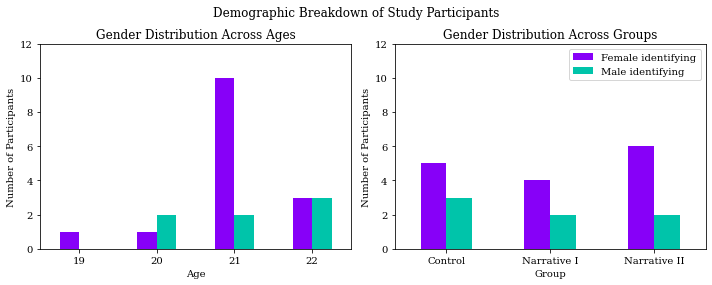

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

groupCounts = participantDf.drop(columns=['ID', 'Name']).groupby(['Group','Gender']).count().unstack()
ax2 = groupCounts.plot(ax=axs[1], rot=0, kind='bar', stacked=False, ylabel="Number of Participants", title="Gender Distribution Across Groups", color=[FEMALE_COL, MALE_COL])

demoCounts = participantDf.drop(columns=['ID', 'Name']).groupby(['Age','Gender']).count().unstack()
ax1 = demoCounts.plot(ax=axs[0], legend=False, rot=0, kind='bar', stacked=False, ylabel="Number of Participants", title="Gender Distribution Across Ages", color=[FEMALE_COL, MALE_COL])

for ax in axs:
  ax.set_ylim(0, 12)

ax2.set_xticklabels(['Control', 'Narrative I', 'Narrative II'])
L=ax2.legend(bbox_to_anchor=(1, 1))
L.get_texts()[0].set_text('Female identifying')
L.get_texts()[1].set_text('Male identifying')

fig.tight_layout()
fig.suptitle("Demographic Breakdown of Study Participants")
fig.subplots_adjust(top=0.85)
fig.savefig(f"{images_dir}demographics.png")
plt.show()

In [27]:
'''Difference in participant scores for total participants'''
df['diff'] = df['postScore']- df['preScore']
df.groupby(['Gender', 'Group']).mean()

preScore  postScore  preThoughtScore  postThoughtScore  \
Gender Group                                                           
female 0      3.700000      4.340         4.085714          4.200000   
       1      3.410714      4.325         3.892857          4.321429   
       2      3.702381      4.450         4.285714          4.357143   
male   0      3.190476      4.300         4.047619          4.190476   
       1      3.428571      4.450         4.000000          4.214286   
       2      3.107143      3.750         3.785714          3.500000   

              preActionScore  postActionScore      diff  
Gender Group                                             
female 0            3.314286         4.666667  0.640000  
       1            2.928571         4.333333  0.914286  
       2            3.119048         4.666667  0.747619  
male   0            2.333333         4.555556  1.109524  
       1            2.857143         5.000000  1.021429  
       2            2.428571         4.333333  0.642857

In [28]:
rp.ttest(df[df['Gender'] == 'female']['diff'], df[df['Gender'] == 'male']['diff'])

(   Variable     N      Mean        SD        SE  95% Conf.  Interval
 0      diff  15.0  0.756190  0.302731  0.078165   0.588543  0.923837
 1      diff   7.0  0.951020  0.368842  0.139409   0.609898  1.292143
 2  combined  22.0  0.818182  0.329537  0.070257   0.672073  0.964290,
             Independent t-test  results
 0  Difference (diff - diff) =   -0.1948
 1        Degrees of freedom =   20.0000
 2                         t =   -1.3138
 3     Two side test p value =    0.2038
 4    Difference < 0 p value =    0.1019
 5    Difference > 0 p value =    0.8981
 6                 Cohen's d =   -0.6014
 7                 Hedge's g =   -0.5785
 8             Glass's delta =   -0.6436
 9               Pearson's r =    0.2819)

##Control Group Score Analysis
* Basic descriptive statistics of control group difference data amongst score breakdowns
* Assumptions to check normalcy
* Two sample t-testing to verify statistically significant differences in samples

###Descriptive Statistics

In [29]:
preControl['ParticipantScore'].describe()

count    8.000000
mean     3.508929
std      0.471394
min      3.071429
25%      3.142857
50%      3.428571
75%      3.660714
max      4.500000
Name: ParticipantScore, dtype: float64

In [30]:
postControl['ParticipantScore'].describe()

count    8.000000
mean     4.325000
std      0.291548
min      3.800000
25%      4.225000
50%      4.400000
75%      4.500000
max      4.700000
Name: ParticipantScore, dtype: float64

In [31]:
'''Difference in participant scores for control group'''
controlDiff = postControl['ParticipantScore']- preControl['ParticipantScore']
controlDiff

5     1.214286
7     0.928571
8     1.257143
9     0.857143
11   -0.100000
12    0.728571
19    0.657143
21    0.985714
Name: ParticipantScore, dtype: float64

In [32]:
'''Average participant score difference for control group'''
controlDiff.describe()

count    8.000000
mean     0.816071
std      0.425666
min     -0.100000
25%      0.710714
50%      0.892857
75%      1.042857
max      1.257143
Name: ParticipantScore, dtype: float64

In [33]:
'''Difference in breakdown of participant scores by thought and action for control group'''
controlThoughtDiff = postControl['ThoughtScore'] - preControl['ThoughtScore']
controlActionDiff = postControl['ActionScore'] - preControl['ActionScore']

###Assumption Checks
* Checking normality

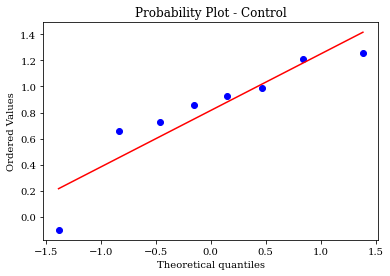

In [34]:
'''Normality assumption check (straight enough)'''
stats.probplot(controlDiff, dist="norm", plot=plt)
plt.title("Probability Plot - Control")
plt.show()

###Significance Testing
* Two sample t-testing of total and breakdown scores

In [35]:
#two-sample t-test to check difference in pre and post participant scores
rp.ttest(postControl['ParticipantScore'], preControl['ParticipantScore'])

(           Variable     N      Mean        SD        SE  95% Conf.  Interval
 0  ParticipantScore   8.0  4.325000  0.291548  0.103078   4.081260  4.568740
 1  ParticipantScore   8.0  3.508929  0.471394  0.166663   3.114834  3.903024
 2          combined  16.0  3.916964  0.566532  0.141633   3.615081  4.218848,
                                   Independent t-test  results
 0  Difference (ParticipantScore - ParticipantScor...   0.8161
 1                              Degrees of freedom =   14.0000
 2                                               t =    4.1644
 3                           Two side test p value =    0.0010
 4                          Difference < 0 p value =    0.9995
 5                          Difference > 0 p value =    0.0005
 6                                       Cohen's d =    2.0822
 7                                       Hedge's g =    1.9686
 8                                   Glass's delta =    2.7991
 9                                     Pearson's r =    0

In [36]:
#two-sample t-test to check difference in pre and post participant thought breakdown scores
rp.ttest(postControl['ThoughtScore'], preControl['ThoughtScore'])

(       Variable     N      Mean        SD        SE  95% Conf.  Interval
 0  ThoughtScore   8.0  4.196429  0.263830  0.093278   3.975861  4.416996
 1  ThoughtScore   8.0  4.071429  0.332847  0.117679   3.793161  4.349696
 2      combined  16.0  4.133929  0.297238  0.074309   3.975542  4.292315,
                             Independent t-test  results
 0  Difference (ThoughtScore - ThoughtScore) =    0.1250
 1                        Degrees of freedom =   14.0000
 2                                         t =    0.8324
 3                     Two side test p value =    0.4191
 4                    Difference < 0 p value =    0.7904
 5                    Difference > 0 p value =    0.2096
 6                                 Cohen's d =    0.4162
 7                                 Hedge's g =    0.3935
 8                             Glass's delta =    0.4738
 9                               Pearson's r =    0.2172)

In [37]:
#two-sample t-test to check difference in pre and post participant action breakdown scores
rp.ttest(postControl['ActionScore'], preControl['ActionScore'])

(      Variable     N      Mean        SD        SE  95% Conf.  Interval
 0  ActionScore   8.0  4.625000  0.415474  0.146892   4.277655  4.972345
 1  ActionScore   8.0  2.946429  0.736145  0.260267   2.330996  3.561861
 2     combined  16.0  3.785714  1.041541  0.260385   3.230716  4.340712,
                           Independent t-test  results
 0  Difference (ActionScore - ActionScore) =    1.6786
 1                      Degrees of freedom =   14.0000
 2                                       t =    5.6166
 3                   Two side test p value =    0.0001
 4                  Difference < 0 p value =    1.0000
 5                  Difference > 0 p value =    0.0000
 6                               Cohen's d =    2.8083
 7                               Hedge's g =    2.6551
 8                           Glass's delta =    4.0401
 9                             Pearson's r =    0.8322)

Results of two sample t-test demonstrate that there likely is no difference in control group thought scores, but a statistically significant difference in control group action scores.

##Narrative I Group Score Analysis
* Basic descriptive statistics of narrative I group difference data amongst score breakdowns
* Assumptions to check normalcy
* Two sample t-testing to verify statistically significant differences in samples

###Descriptive Statistics

In [38]:
preN1['ParticipantScore'].describe()

count    6.000000
mean     3.416667
std      0.379088
min      2.857143
25%      3.178571
50%      3.500000
75%      3.714286
max      3.785714
Name: ParticipantScore, dtype: float64

In [39]:
postN1['ParticipantScore'].describe()

count    6.000000
mean     4.366667
std      0.377712
min      3.800000
25%      4.150000
50%      4.400000
75%      4.650000
max      4.800000
Name: ParticipantScore, dtype: float64

In [40]:
'''Difference in participant scores for n1 group'''
n1Diff = postN1['ParticipantScore'] - preN1['ParticipantScore']
n1Diff

2     0.914286
3     0.800000
4     0.942857
10    1.028571
16    1.014286
22    1.000000
Name: ParticipantScore, dtype: float64

In [41]:
'''Average participant score difference for n1 group'''
n1Diff.describe()

count    6.000000
mean     0.950000
std      0.085595
min      0.800000
25%      0.921429
50%      0.971429
75%      1.010714
max      1.028571
Name: ParticipantScore, dtype: float64

In [42]:
'''Difference in breakdown of participant scores by thought and action for n1 group'''
n1ThoughtDiff = postN1['ThoughtScore'] - preN1['ThoughtScore']
n1ActionDiff = postN1['ActionScore'] - preN1['ActionScore']

###Assumption Checks
* Checking normality

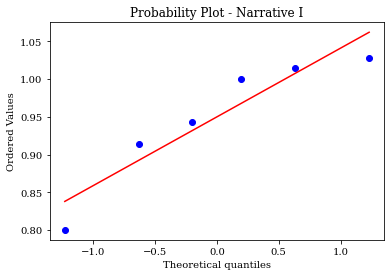

In [43]:
'''Normality assumption check (straight enough)'''
stats.probplot(n1Diff, dist="norm", plot=plt)
plt.title("Probability Plot - Narrative I")
plt.show()

###Significance Testing
* Two sample t-testing of total and breakdown scores

In [44]:
#two-sample t-test to check difference in pre and post participant scores
rp.ttest(postN1['ParticipantScore'], preN1['ParticipantScore'])

(           Variable     N      Mean        SD        SE  95% Conf.  Interval
 0  ParticipantScore   6.0  4.366667  0.377712  0.154200   3.970282  4.763052
 1  ParticipantScore   6.0  3.416667  0.379088  0.154762   3.018839  3.814495
 2          combined  12.0  3.891667  0.613438  0.177084   3.501907  4.281427,
                                   Independent t-test  results
 0  Difference (ParticipantScore - ParticipantScor...   0.9500
 1                              Degrees of freedom =   10.0000
 2                                               t =    4.3484
 3                           Two side test p value =    0.0014
 4                          Difference < 0 p value =    0.9993
 5                          Difference > 0 p value =    0.0007
 6                                       Cohen's d =    2.5106
 7                                       Hedge's g =    2.3174
 8                                   Glass's delta =    2.5151
 9                                     Pearson's r =    0

In [45]:
#two-sample t-test to check difference in pre and post participant thought breakdown scores
rp.ttest(postN1['ThoughtScore'], preN1['ThoughtScore'])

(       Variable     N      Mean        SD        SE  95% Conf.  Interval
 0  ThoughtScore   6.0  4.285714  0.451754  0.184428   3.811628  4.759801
 1  ThoughtScore   6.0  3.928571  0.369777  0.150961   3.540515  4.316628
 2      combined  12.0  4.107143  0.435549  0.125732   3.830408  4.383878,
                             Independent t-test  results
 0  Difference (ThoughtScore - ThoughtScore) =    0.3571
 1                        Degrees of freedom =   10.0000
 2                                         t =    1.4985
 3                     Two side test p value =    0.1649
 4                    Difference < 0 p value =    0.9176
 5                    Difference > 0 p value =    0.0824
 6                                 Cohen's d =    0.8652
 7                                 Hedge's g =    0.7986
 8                             Glass's delta =    0.7906
 9                               Pearson's r =    0.4282)

In [46]:
#two-sample t-test to check difference in pre and post participant action breakdown scores
rp.ttest(postN1['ActionScore'], preN1['ActionScore'])

(      Variable     N      Mean        SD        SE  95% Conf.  Interval
 0  ActionScore   6.0  4.555556  0.583730  0.238307   3.942968  5.168143
 1  ActionScore   6.0  2.904762  0.448732  0.183194   2.433846  3.375677
 2     combined  12.0  3.730159  0.994799  0.287174   3.098094  4.362224,
                           Independent t-test  results
 0  Difference (ActionScore - ActionScore) =    1.6508
 1                      Degrees of freedom =   10.0000
 2                                       t =    5.4920
 3                   Two side test p value =    0.0003
 4                  Difference < 0 p value =    0.9999
 5                  Difference > 0 p value =    0.0001
 6                               Cohen's d =    3.1708
 7                               Hedge's g =    2.9269
 8                           Glass's delta =    2.8280
 9                             Pearson's r =    0.8666)

Results of two sample t-test demonstrate that there likely is a difference in both thought and action scores of the narrative I group.

##Narrative II Group Score Analysis
* Basic descriptive statistics of narrative II group difference data amongst score breakdowns
* Assumptions to check normalcy
* Two sample t-testing to verify statistically significant differences in samples

###Descriptive Statistics

In [47]:
preN2['ParticipantScore'].describe()

count    8.000000
mean     3.553571
std      0.491547
min      2.785714
25%      3.232143
50%      3.571429
75%      3.964286
max      4.142857
Name: ParticipantScore, dtype: float64

In [48]:
postN2['ParticipantScore'].describe()

count    8.000000
mean     4.275000
std      0.439968
min      3.600000
25%      3.900000
50%      4.350000
75%      4.625000
max      4.800000
Name: ParticipantScore, dtype: float64

In [49]:
'''Difference in participant scores for n1 group'''
n2Diff = postN2['ParticipantScore'] - preN2['ParticipantScore']
n2Diff

1     0.885714
6     0.171429
13    0.557143
14    1.128571
15    1.114286
17    0.428571
18    0.614286
20    0.871429
Name: ParticipantScore, dtype: float64

In [50]:
'''Average participant score difference for n2 group'''
n2Diff.describe()

count    8.000000
mean     0.721429
std      0.337285
min      0.171429
25%      0.525000
50%      0.742857
75%      0.942857
max      1.128571
Name: ParticipantScore, dtype: float64

In [51]:
'''Difference in breakdown of participant scores by thought and action for n2 group'''
n2ThoughtDiff = postN2['ThoughtScore'] - preN2['ThoughtScore']
n2ActionDiff = postN2['ActionScore'] - preN2['ActionScore']

In [52]:
n2ActionDiff.mean()

1.6369047619047619

In [53]:
n1ActionDiff.mean()

1.650793650793651

In [54]:
controlActionDiff.mean()

1.6785714285714288

###Assumption Checks

* Checking normality

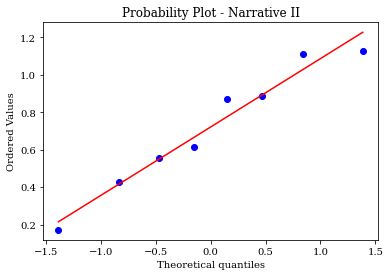

In [55]:
'''Normality assumption check (straight enough)'''
stats.probplot(n2Diff, dist="norm", plot=plt)
plt.title("Probability Plot - Narrative II")
plt.show()

###Significance Testing
* Two sample t-testing of total and breakdown scores

In [56]:
#two-sample t-test to check difference in pre and post participant scores
rp.ttest(postN2['ParticipantScore'], preN2['ParticipantScore'])

(           Variable     N      Mean        SD        SE  95% Conf.  Interval
 0  ParticipantScore   8.0  4.275000  0.439968  0.155552   3.907178  4.642822
 1  ParticipantScore   8.0  3.553571  0.491547  0.173788   3.142628  3.964515
 2          combined  16.0  3.914286  0.584703  0.146176   3.602719  4.225852,
                                   Independent t-test  results
 0  Difference (ParticipantScore - ParticipantScor...   0.7214
 1                              Degrees of freedom =   14.0000
 2                                               t =    3.0931
 3                           Two side test p value =    0.0079
 4                          Difference < 0 p value =    0.9960
 5                          Difference > 0 p value =    0.0040
 6                                       Cohen's d =    1.5466
 7                                       Hedge's g =    1.4622
 8                                   Glass's delta =    1.6397
 9                                     Pearson's r =    0

In [57]:
#two-sample t-test to check difference in pre and post participant thought breakdown scores
rp.ttest(postN2['ThoughtScore'], preN2['ThoughtScore'])

(       Variable     N      Mean        SD        SE  95% Conf.  Interval
 0  ThoughtScore   8.0  4.142857  0.458162  0.161985   3.759824  4.525890
 1  ThoughtScore   8.0  4.160714  0.385128  0.136163   3.838739  4.482689
 2      combined  16.0  4.151786  0.408977  0.102244   3.933857  4.369714,
                             Independent t-test  results
 0  Difference (ThoughtScore - ThoughtScore) =   -0.0179
 1                        Degrees of freedom =   14.0000
 2                                         t =   -0.0844
 3                     Two side test p value =    0.9339
 4                    Difference < 0 p value =    0.4670
 5                    Difference > 0 p value =    0.5330
 6                                 Cohen's d =   -0.0422
 7                                 Hedge's g =   -0.0399
 8                             Glass's delta =   -0.0390
 9                               Pearson's r =    0.0225)

In [58]:
#two-sample t-test to check difference in pre and post participant action breakdown scores
rp.ttest(postN2['ActionScore'], preN2['ActionScore'])

(      Variable     N      Mean        SD        SE  95% Conf.  Interval
 0  ActionScore   8.0  4.583333  0.610750  0.215933   4.072733  5.093933
 1  ActionScore   8.0  2.946429  0.638591  0.225776   2.412553  3.480304
 2     combined  16.0  3.764881  1.038702  0.259676   3.211396  4.318366,
                           Independent t-test  results
 0  Difference (ActionScore - ActionScore) =    1.6369
 1                      Degrees of freedom =   14.0000
 2                                       t =    5.2396
 3                   Two side test p value =    0.0001
 4                  Difference < 0 p value =    0.9999
 5                  Difference > 0 p value =    0.0001
 6                               Cohen's d =    2.6198
 7                               Hedge's g =    2.4769
 8                           Glass's delta =    2.6802
 9                             Pearson's r =    0.8138)

Results from two-sample t-test show that there is a not a statistically significant difference in narrative II group thought scores, but a significant difference in action scores.

##Total Participants Score Analysis
* Basic descriptive statistics of total dataframe difference data amongst participant score breakdowns
* Assumptions to check homogeniety of variance for dataset
* One-way ANOVA & ANCOVA testing to test difference in participant scores and breakdown amongst groups

###Descriptive Statistics

In [59]:
totalDf.groupby("Group")["preScore", "postScore"].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


preScore                                                              \
         count      mean       std       min       25%       50%       75%   
Group                                                                        
0          8.0  3.508929  0.471394  3.071429  3.142857  3.428571  3.660714   
1          6.0  3.416667  0.379088  2.857143  3.178571  3.500000  3.714286   
2          8.0  3.553571  0.491547  2.785714  3.232143  3.571429  3.964286   

                postScore                                                    
            max     count      mean       std  min    25%   50%    75%  max  
Group                                                                        
0      4.500000       8.0  4.325000  0.291548  3.8  4.225  4.40  4.500  4.7  
1      3.785714       6.0  4.366667  0.377712  3.8  4.150  4.40  4.650  4.8  
2      4.142857       8.0  4.275000  0.439968  3.6  3.900  4.35  4.625  4.8

In [60]:
totalDf.groupby("Group")["preThoughtScore", "postThoughtScore"].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


preThoughtScore                                                    \
                count      mean       std       min       25%       50%   
Group                                                                     
0                 8.0  4.071429  0.332847  3.571429  3.821429  4.142857   
1                 6.0  3.928571  0.369777  3.428571  3.678571  4.000000   
2                 8.0  4.160714  0.385128  3.571429  3.964286  4.071429   

                          postThoughtScore                                \
            75%       max            count      mean       std       min   
Group                                                                      
0      4.285714  4.571429              8.0  4.196429  0.263830  3.714286   
1      4.107143  4.428571              6.0  4.285714  0.451754  3.714286   
2      4.464286  4.714286              8.0  4.142857  0.458162  3.428571   

                                               
            25%       50%       75%       max  
Group                                          
0      4.107143  4.214286  4.321429  4.571429  
1      3.892857  4.500000  4.571429  4.714286  
2      3.892857  4.214286  4.464286  4.714286

In [61]:
totalDf.groupby("Group")["preActionScore", "postActionScore"].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


preActionScore                                                    \
               count      mean       std       min       25%       50%   
Group                                                                    
0                8.0  2.946429  0.736145  2.142857  2.500000  2.785714   
1                6.0  2.904762  0.448732  2.285714  2.642857  2.928571   
2                8.0  2.946429  0.638591  2.000000  2.500000  3.000000   

                          postActionScore                                \
            75%       max           count      mean       std       min   
Group                                                                     
0      3.285714  4.428571             8.0  4.625000  0.415474  4.000000   
1      3.107143  3.571429             6.0  4.555556  0.583730  3.666667   
2      3.357143  3.857143             8.0  4.583333  0.610750  3.333333   

                                     
            25%       50%  75%  max  
Group                                
0      4.500000  4.666667  5.0  5.0  
1      4.166667  4.833333  5.0  5.0  
2      4.500000  4.833333  5.0  5.0

In [62]:
totalDf.describe()

,preScore,postScore,preThoughtScore,postThoughtScore,preActionScore,postActionScore
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,3.500000,4.318182,4.064935,4.201299,2.935065,4.590909
std,0.438103,0.358085,0.357421,0.380933,0.604047,0.513643
min,2.785714,3.600000,3.428571,3.428571,2.000000,3.333333
25%,3.142857,4.025000,3.857143,4.000000,2.571429,4.166667
50%,3.500000,4.400000,4.071429,4.285714,2.928571,4.666667
75%,3.767857,4.575000,4.285714,4.535714,3.285714,5.000000
max,4.500000,4.800000,4.714286,4.714286,4.428571,5.000000


In [63]:
'''Difference in participant scores for total participants'''
totalDiff = postEnvDf['ParticipantScore'] - preEnvDf['ParticipantScore']
totalDiff.describe()

count    22.000000
mean      0.818182
std       0.329537
min      -0.100000
25%       0.675000
50%       0.900000
75%       1.010714
max       1.257143
Name: ParticipantScore, dtype: float64

In [64]:
thoughtDiff = postEnvDf['ThoughtScore'] - preEnvDf['ThoughtScore']
thoughtDiff.describe()

count    22.000000
mean      0.136364
std       0.280487
min      -0.571429
25%       0.000000
50%       0.142857
75%       0.285714
max       0.571429
Name: ThoughtScore, dtype: float64

In [65]:
actionDiff = postEnvDf['ActionScore'] - preEnvDf['ActionScore']
actionDiff.describe()

count    22.000000
mean      1.655844
std       0.645590
min       0.238095
25%       1.428571
50%       1.714286
75%       1.857143
max       2.857143
Name: ActionScore, dtype: float64

####Figuring out why some thought scores were negative

In [66]:
totalNegDiffIds = totalDf[totalDf["preScore"] > totalDf["postScore"]]["ID"]

In [67]:
totalNegThoughtDiffIds = totalDf[totalDf["preThoughtScore"] > totalDf["postThoughtScore"]]["ID"]

In [68]:
thoughtQs = ['Q' + str(i) for i in range(1,8)]

In [69]:
# these cols are reverse coded: ['Q3', 'Q5', 'Q6', 'Q7']
for id in totalNegThoughtDiffIds:
  print("Looking at participant id "+id+"...")
  print("This participant is in group", participantDf[participantDf["ID"] == id]["Group"].item())
  for q in thoughtQs:
    pre = preEnvDf[preEnvDf["ID"] == id][q].item()
    post = postEnvDf[postEnvDf["ID"] == id][q].item()
    if pre > post:
      print("Participant "+str(id)+" decreased in thought on "+str(q)+" from "+str(pre)+" to "+str(post));
      if q in cols:
        print("---This question was reverse coded!")
  print("\n")

Looking at participant id 10...
This participant is in group 2
Participant 10 decreased in thought on Q5 from 4 to 2
---This question was reverse coded!
Participant 10 decreased in thought on Q6 from 4 to 2
---This question was reverse coded!


Looking at participant id 19...
This participant is in group 0
Participant 19 decreased in thought on Q1 from 4 to 3
Participant 19 decreased in thought on Q2 from 5 to 4
Participant 19 decreased in thought on Q3 from 5 to 4
---This question was reverse coded!


Looking at participant id 8...
This participant is in group 2
Participant 8 decreased in thought on Q1 from 4 to 2


Looking at participant id 7...
This participant is in group 0
Participant 7 decreased in thought on Q5 from 5 to 4
---This question was reverse coded!
Participant 7 decreased in thought on Q6 from 5 to 4
---This question was reverse coded!




###Assumption Checks
* Homogeneity of assumption ratio

In [70]:
'''Homogeneity of assumption check (checking if ratio of 
largest to smallest standard deviation is less than two)'''

diffByGroupDf = pd.concat([totalDiff, preEnvDf['Group']], axis=1, keys=['totalDiff', 'Group'])

ratio = diffByGroupDf.groupby('Group').std().max() / diffByGroupDf.groupby('Group').std().min()
ratio

totalDiff    4.973017
dtype: float64

###Significance Testing
* two-sample t-testing
* one-way ANOVA testing
* ANCOVA testing

In [71]:
#results from two-sample t-test to show statistically significant difference between participant score means
rp.ttest(postEnvDf['ParticipantScore'], preEnvDf['ParticipantScore'])

(           Variable     N      Mean        SD        SE  95% Conf.  Interval
 0  ParticipantScore  22.0  4.318182  0.358085  0.076344   4.159416  4.476948
 1  ParticipantScore  22.0  3.500000  0.438103  0.093404   3.305756  3.694244
 2          combined  44.0  3.909091  0.572367  0.086288   3.735075  4.083106,
                                   Independent t-test  results
 0  Difference (ParticipantScore - ParticipantScor...   0.8182
 1                              Degrees of freedom =   42.0000
 2                                               t =    6.7823
 3                           Two side test p value =    0.0000
 4                          Difference < 0 p value =    1.0000
 5                          Difference > 0 p value =    0.0000
 6                                       Cohen's d =    2.0449
 7                                       Hedge's g =    2.0082
 8                                   Glass's delta =    2.2849
 9                                     Pearson's r =    0

In [72]:
#results from two-sample t-test to show statistically significant difference between thought score means
rp.ttest(postEnvDf['ThoughtScore'], preEnvDf['ThoughtScore'])

(       Variable     N      Mean        SD        SE  95% Conf.  Interval
 0  ThoughtScore  22.0  4.201299  0.380933  0.081215   4.032402  4.370195
 1  ThoughtScore  22.0  4.064935  0.357421  0.076202   3.906463  4.223407
 2      combined  44.0  4.133117  0.371502  0.056006   4.020170  4.246064,
                             Independent t-test  results
 0  Difference (ThoughtScore - ThoughtScore) =    0.1364
 1                        Degrees of freedom =   42.0000
 2                                         t =    1.2244
 3                     Two side test p value =    0.2276
 4                    Difference < 0 p value =    0.8862
 5                    Difference > 0 p value =    0.1138
 6                                 Cohen's d =    0.3692
 7                                 Hedge's g =    0.3626
 8                             Glass's delta =    0.3580
 9                               Pearson's r =    0.1857)

In [73]:
#results from two-sample t-test to show statistically significant difference between action score means
rp.ttest(postEnvDf['ActionScore'], preEnvDf['ActionScore'])

(      Variable     N      Mean        SD        SE  95% Conf.  Interval
 0  ActionScore  22.0  4.590909  0.513643  0.109509   4.363173  4.818645
 1  ActionScore  22.0  2.935065  0.604047  0.128783   2.667245  3.202885
 2     combined  44.0  3.762987  1.004209  0.151390   3.457679  4.068295,
                           Independent t-test  results
 0  Difference (ActionScore - ActionScore) =    1.6558
 1                      Degrees of freedom =   42.0000
 2                                       t =    9.7951
 3                   Two side test p value =    0.0000
 4                  Difference < 0 p value =    1.0000
 5                  Difference > 0 p value =    0.0000
 6                               Cohen's d =    2.9533
 7                               Hedge's g =    2.9003
 8                           Glass's delta =    3.2237
 9                             Pearson's r =    0.8340)

There exists a statistically significant difference between pre and post total environmental participant scores, as well as action breakdown scores across all three groups. This is not the case for the thought score breakdown—there is not enough evidence to suggest there is a difference between pre and post intervention thought scores.

In [74]:
#one way anova test for difference in group participant score differences
stats.f_oneway(controlDiff, n1Diff, n2Diff)

F_onewayResult(statistic=0.8100804453464971, pvalue=0.4596049929313109)

In [75]:
#one way anova test for difference in group thought breakdown of participant score differences
stats.f_oneway(controlThoughtDiff, n1ThoughtDiff, n2ThoughtDiff)

F_onewayResult(statistic=3.933505359269557, pvalue=0.037202780301007814)

In [76]:
#one way anova test for difference in group action breakdown of participant score differences
stats.f_oneway(controlActionDiff, n1ActionDiff, n2ActionDiff)

F_onewayResult(statistic=0.007772270080369616, pvalue=0.9922610089592867)

In [77]:
'''ANCOVA Testing for Covariance, controling for pre environmental score values'''
ancova(data=totalDf, dv='postScore', covar='preScore', between='Group')

,Source,SS,DF,F,p-unc,np2
0,Group,0.097346,2,0.639001,0.539379,0.066293
1,preScore,1.292268,1,16.965520,0.000645,0.485207
2,Residual,1.371065,18,NaN,NaN,NaN


In [78]:
'''ANCOVA Testing for Covariance of thought scores, controling for pre environmental thought score values'''
ancova(data=totalDf, dv='postThoughtScore', covar='preThoughtScore', between='Group')

,Source,SS,DF,F,p-unc,np2
0,Group,0.376765,2,3.025208,0.073680,0.251572
1,preThoughtScore,1.856163,1,29.807833,0.000035,0.623493
2,Residual,1.120878,18,NaN,NaN,NaN


In [79]:
'''ANCOVA Testing for Covariance of action scores, controling for pre environmental action score values'''
ancova(data=totalDf, dv='postActionScore', covar='preActionScore', between='Group')

,Source,SS,DF,F,p-unc,np2
0,Group,0.012767,2,0.023539,0.976766,0.002609
1,preActionScore,0.641673,1,2.366110,0.141389,0.116179
2,Residual,4.881475,18,NaN,NaN,NaN


There does not exist a statistically significant difference between participant and action scores amongst groups for both ANOVA and ANCOVA testing, however, there may be evidence of a difference in thought scores.

####Non-parametric testing
use this!! data not normal

In [80]:
stats.kruskal(controlDiff, n1Diff, n2Diff)

KruskalResult(statistic=1.9841897233201564, pvalue=0.37079910401121946)

In [81]:
stats.kruskal(controlThoughtDiff, n1ThoughtDiff, n2ThoughtDiff)

KruskalResult(statistic=7.1654999999999935, pvalue=0.027799145393474348)

In [82]:
stats.kruskal(controlActionDiff, n1ActionDiff, n2ActionDiff)

KruskalResult(statistic=0.12989845537757516, pvalue=0.9371150416661007)

In [83]:
stats.kruskal(postEnvDf['ParticipantScore'], preEnvDf['ParticipantScore'])

KruskalResult(statistic=23.216442263220085, pvalue=1.4475438669087056e-06)

In [84]:
stats.kruskal(postEnvDf['ThoughtScore'], preEnvDf['ThoughtScore'])

KruskalResult(statistic=1.7829397706165813, pvalue=0.18178875350883805)

In [85]:
stats.kruskal(postEnvDf['ActionScore'], preEnvDf['ActionScore'])

KruskalResult(statistic=30.14800244890517, pvalue=4.002992848070705e-08)

###Visualizations
* Total Environmental Engagement Score by Group
* Thought Breakdown of Environmental Engagement Score by Group
* Action Breakdown of Environmental Engagement Score by Group

In [86]:
labels = ['Control', 'Narrative I', 'Narrative II']

In [87]:
pre_means = [preControl['ParticipantScore'].mean(), preN1['ParticipantScore'].mean(), preN2['ParticipantScore'].mean()]
post_means = [postControl['ParticipantScore'].mean(), postN1['ParticipantScore'].mean(), postN2['ParticipantScore'].mean()]

In [88]:
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

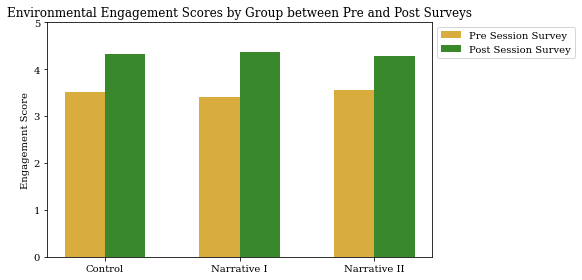

In [95]:
'''Environmental Engagement Score Graph'''
fig, ax = plt.subplots(figsize=(8,4))

rects1 = ax.bar(x - width/2, pre_means, width, label='Pre Session Survey', color=PRE_COLOR)
rects3 = ax.bar(x + width/2, post_means, width, label='Post Session Survey', color=POST_COLOR)

ax.set_ylabel('Engagement Score')
ax.set_title('Environmental Engagement Scores by Group between Pre and Post Surveys')
ax.set_xticks(x)
ax.set_ylim(0, 5)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1, 1))
fig.tight_layout()
fig.savefig(f"{images_dir}env_eng.png")
plt.show()

In [90]:
pre_thought_means = [preControl['ThoughtScore'].mean(), preN1['ThoughtScore'].mean(), preN2['ThoughtScore'].mean()]
post_thought_means = [postControl['ThoughtScore'].mean(), postN1['ThoughtScore'].mean(), postN2['ThoughtScore'].mean()]

In [91]:
pre_action_means = [preControl['ActionScore'].mean(), preN1['ActionScore'].mean(), preN2['ActionScore'].mean()]
post_action_means = [postControl['ActionScore'].mean(), postN1['ActionScore'].mean(), postN2['ActionScore'].mean()]

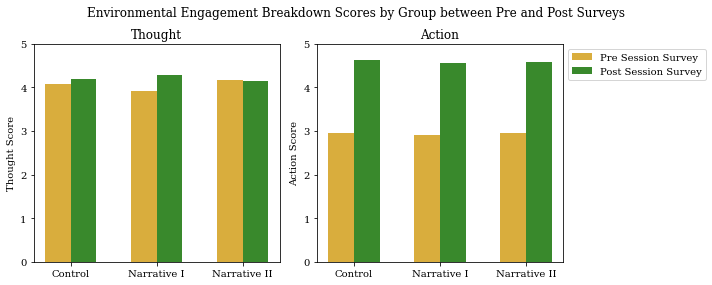

In [94]:
'''Environmental Thought Engagement Score Graph'''
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.bar(x - width/2, pre_thought_means, width, label='Pre Session Survey', color=PRE_COLOR)
ax1.bar(x + width/2, post_thought_means, width, label='Post Session Survey', color=POST_COLOR)

ax1.set_ylabel('Thought Score')
ax1.set_xticks(x)
ax1.set_title('Thought')
ax1.set_xticklabels(labels)
ax1.set_ylim(0, 5)
# ax.legend(bbox_to_anchor=(1, 1))
# fig.tight_layout()
# fig.savefig(f"{images_dir}env_eng_thought.png")
# plt.show()

'''Environmental Engagement Score Graph'''
#fig, ax = plt.subplots(figsize=(8,4))

ax2.bar(x - width/2, pre_action_means, width, label='Pre Session Survey', color=PRE_COLOR)
ax2.bar(x + width/2, post_action_means, width, label='Post Session Survey', color=POST_COLOR)

ax2.set_ylabel('Action Score')
ax2.set_ylim(0, 5)
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.set_title('Action')
ax2.legend(bbox_to_anchor=(1, 1))
fig.tight_layout()
fig.suptitle('Environmental Engagement Breakdown Scores by Group between Pre and Post Surveys')
fig.subplots_adjust(top=0.85)
fig.savefig(f"{images_dir}env_eng_breakdown.png")
fig.show()